<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/Deep_Learning_Silant_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Silant Problem using ViT

I'll use Transfer learning using ViT to detect the defect and normal silant. I'm not sure if I can upload the image to the Googld Drive or not.

In [1]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt
print(f"torch version : {torch.__version__}")

torch version : 2.5.0+cu121


In [2]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'Artificial_Intelligence'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 210 (delta 74), reused 62 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (210/210), 16.73 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
image_path = "/content/drive/MyDrive/data"

In [5]:
# Setup directory paths to train and test images
train_dir = image_path + "/train"
test_dir = image_path + "/test"
print(train_dir, test_dir)

/content/drive/MyDrive/data/train /content/drive/MyDrive/data/test


In [6]:
from torchvision import transforms
from pytorch_modules.pytorch_modules import data_setup

# Create image size
IMG_SIZE = 224  # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our small model)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(60, 14, ['defect', 'normal'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

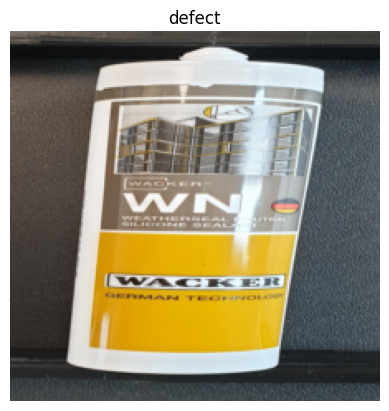

In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 83.1MB/s]


In [11]:
# Create an instance of Transformerblock
summary(model=pretrained_vit,
        input_size = (1,3, 224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 16,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 2]           768              Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)        False
├─Encoder (encoder)                                          [1, 197, 768]    [1, 197, 768]    151,296          False
│    └─Dropout (dropout)                                     [1, 197, 768]    [1, 197, 768]    --               --
│    └─Sequential (layers)                                   [1, 197, 768]    [1, 197, 768]    --               False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]    [1, 197, 768]    (7,087,872)      False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]    [1, 197, 768]    (7,087,872)      False
│    │    └─EncoderBlock (encoder_layer_2)           

In [12]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
#Set up dataloaders
from pytorch_modules.pytorch_modules import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)


In [14]:
len(class_names)

2

In [15]:
from pytorch_modules.pytorch_modules import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3072 | train_acc: 0.8849 | test_loss: 0.2096 | test_acc: 0.9034
Epoch: 2 | train_loss: 0.1648 | train_acc: 0.9344 | test_loss: 0.1337 | test_acc: 0.9561
Epoch: 3 | train_loss: 0.1106 | train_acc: 0.9625 | test_loss: 0.0964 | test_acc: 0.9640
Epoch: 4 | train_loss: 0.0823 | train_acc: 0.9802 | test_loss: 0.0775 | test_acc: 0.9884
Epoch: 5 | train_loss: 0.0645 | train_acc: 0.9859 | test_loss: 0.0630 | test_acc: 0.9955
Epoch: 6 | train_loss: 0.0530 | train_acc: 0.9922 | test_loss: 0.0497 | test_acc: 0.9929
Epoch: 7 | train_loss: 0.0438 | train_acc: 0.9953 | test_loss: 0.0431 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0378 | train_acc: 0.9958 | test_loss: 0.0357 | test_acc: 0.9978
Epoch: 9 | train_loss: 0.0328 | train_acc: 0.9964 | test_loss: 0.0323 | test_acc: 0.9978
Epoch: 10 | train_loss: 0.0285 | train_acc: 0.9974 | test_loss: 0.0272 | test_acc: 0.9978


## Saving the Model

In [16]:
from pytorch_modules.pytorch_modules import utils

utils.save_model(model=pretrained_vit,
                 target_dir="/content/drive/MyDrive/models",
                 model_name="pretrained_vit_silant.pth")

[INFO] Saving model to: models/pretrained_vit_silant.pth


## Checking if it works well
We are testing some images and calculating Confusion Matrix, F1 Score, ROC Curve

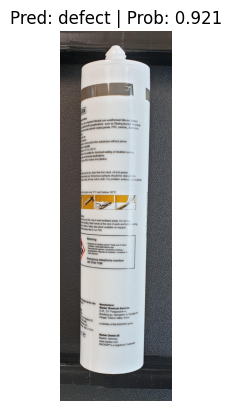

In [17]:
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image
normal_image = "/content/drive/MyDrive/data/test/defect/20240823_110442.jpg"

pred_and_plot_image(model=pretrained_vit,
                           image_path=normal_image,
                           class_names=class_names)

In [32]:
from pathlib import Path

pretrained_vit_model_size = Path("/content/drive/MyDrive/models/pretrained_vit_silant.pth").stat().st_size
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 343263306 MB


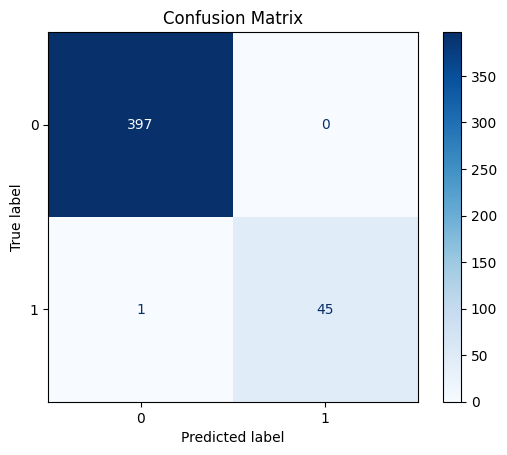

In [34]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming you have a test DataLoader (test_dataloader_pretrained) and the model (pretrained_vit)
# Ensure the model is in evaluation mode
pretrained_vit.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Move model to the appropriate device (e.g., CPU or GPU)
pretrained_vit.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in test_dataloader_pretrained:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = pretrained_vit(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


F1 Score (Micro): 0.9977426636568849
F1 Score (Macro): 0.9938765636878845


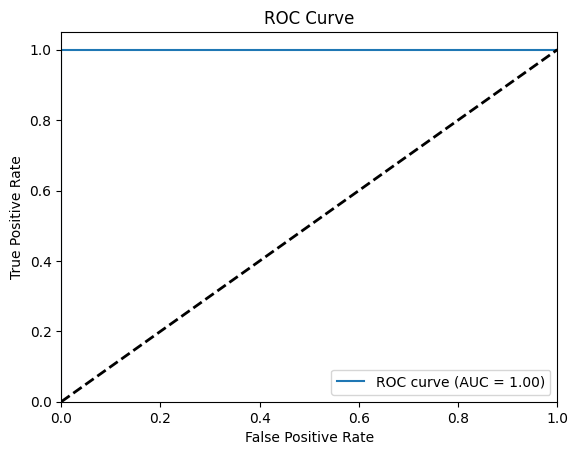

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import numpy as np
from sklearn.preprocessing import label_binarize

# Assuming you have a test DataLoader (test_dataloader_pretrained) and the model (pretrained_vit)
# Ensure the model is in evaluation mode
pretrained_vit.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []
all_probabilities = []

# Move model to the appropriate device (e.g., CPU or GPU)
pretrained_vit.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in test_dataloader_pretrained:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = pretrained_vit(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions, true labels, and predicted probabilities
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate F1 score (micro and macro)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

# Determine if it's binary or multi-class
num_classes = len(np.unique(true_labels))

if num_classes == 2:
    # Binary classification: Use only one ROC curve
    fpr, tpr, _ = roc_curve(true_labels, np.array(all_probabilities)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
else:
    # Multi-class classification: ROC curve for each class
    true_labels_binarized = label_binarize(true_labels, classes=np.arange(num_classes))

    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], np.array(all_probabilities)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
